<a href="https://colab.research.google.com/github/mfz/fastbook/blob/master/My_MNIST_SAMPLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
! curl -s https://course.fast.ai/setup/colab | bash
! pip install fastai2
! pip install nbdev
! pip install azure-cognitiveservices-search-imagesearch


In [0]:
from fastai2.vision.all import *
from nbdev.showdoc import *
from ipywidgets import widgets
from pandas.api.types import CategoricalDtype

import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 200
mpl.rcParams['savefig.dpi']= 200
mpl.rcParams['font.size']=12

set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pd.set_option('display.max_columns',999)
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=200)

matplotlib.rc('image', cmap='Greys')

## MNIST data set

Load MNIST sample set

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

and check what's available

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

In [5]:
(path/"train").ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [6]:
threes = (path/"train"/"3").ls().sorted()
im3 = Image.open(threes[1])
im3

In [7]:
sevens = (path/"train"/"7").ls().sorted()
im7 = Image.open(sevens[3])
im7

convert to torch tensors and average over all sample images

In [0]:
threes_tens = torch.stack([tensor(Image.open(f)) for f in threes]).float()/255
sevens_tens = torch.stack([tensor(Image.open(f)) for f in sevens]).float()/255

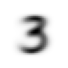

In [9]:
three_mean = threes_tens.mean(0)
show_image(three_mean)

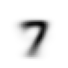

In [10]:
seven_mean = sevens_tens.mean(0)
show_image(seven_mean)

### Baseline classifier

our baseline classifier will be the sum of abs diff from mean

In [11]:
(threes_tens[3] - three_mean).abs().sum()


tensor(90.4458)

In [12]:
(threes_tens[3] - seven_mean).abs().sum()

tensor(130.8637)

In [0]:
def is_three(x): return (x - three_mean).abs().mean() < (x - seven_mean).abs().mean()

In [14]:
np.mean([is_three(threes_tens[i]) for i in range(threes_tens.size()[0]) ])

0.8912086119719459

In [15]:
np.mean([is_three(sevens_tens[i]) for i in range(sevens_tens.size()[0]) ])

0.003830806065442937

## NN
### Create DataLoader

DataLoader allows batching and sampling from data set. A data set is simply a list of (x, y) tuples.


In [0]:
train_x = torch.cat((threes_tens, sevens_tens)).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens))
train = list(zip(train_x, train_y))
train_dl = DataLoader(train, bs=256)

In [0]:
valid_3_tens = [tensor(Image.open(f)) for f in (path/"valid"/"3").ls()]
valid_7_tens = [tensor(Image.open(f)) for f in (path/"valid"/"7").ls()]
valid_x = torch.cat((torch.stack(valid_3_tens).float()/255, 
                     torch.stack(valid_7_tens).float()/255)).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens))
valid = list(zip(valid_x, valid_y))
valid_dl = DataLoader(valid, bs=256)

In [19]:
valid_dl

In [20]:
x, y = first(valid_dl)
x.size(), y.size()

(torch.Size([256, 784]), torch.Size([256]))

In [0]:
def myloss(target, pred): return torch.where(target==0, pred, 1-pred).mean()

In [0]:
def train_epoch(model, dl, lr, loss_func, params):
  for x,y in dl:
    loss = loss_func(y, sigmoid(model(x)))
    loss.backward()
    for p in params:
      p.data -= lr*p.grad
      p.grad.zero_()


In [0]:
def validate(model, metrics):
  m = []
  for x,y in valid_dl:
    pred = sigmoid(model(x))
    m.append(metrics(y, pred))
  return np.mean(m)

In [0]:
def accuracy(y, pred):
  return ((pred > 0.5)==y).float().mean()
  

In [0]:
model = nn.Sequential(nn.Linear(784, 10),
                nn.ReLU(),
                nn.Linear(10, 1))

ps = params(model)

In [146]:
for epoch in range(50):
  print(validate(model, accuracy))
  train_epoch(model, train_dl, 0.1, myloss, ps)


0.48662648
0.50683594
0.79380035
0.905101
0.9282791
0.94353026
0.9521057
0.9544403
0.9544403
0.9563934
0.95780486
0.9592163
0.961116
0.96198577
0.96247405
0.9639389
0.96540374
0.965892
0.965892
0.965892
0.9663803
0.9663803
0.9663803
0.9668686
0.96735686
0.96784514
0.9683334
0.9683334
0.9683334
0.9683334
0.9683334
0.96784514
0.9687683
0.9692566
0.9692566
0.96974486
0.97023314
0.97023314
0.97023314
0.97023314
0.96974486
0.96974486
0.96974486
0.96974486
0.96974486
0.96974486
0.96974486
0.96974486
0.96974486
0.96974486
